In [1]:
! pip install pyspark -q

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

sc = SparkContext.getOrCreate()

spark = SparkSession\
    .builder\
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .appName('BDA_Project')\
    .getOrCreate()

In [3]:
# Path to the Parquet file
data_path = "/content/BDA_EDA_Model_SAMPLE_DATA.snappy.parquet"

df_sampled = spark.read.parquet(data_path)

In [4]:
df_sampled.printSchema()

root
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- travelDuration: integer (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- search_day_of_week: integer (nullable = true)
 |-- search_month: integer (nullable = true)
 |-- search_week_of_year: integer (nullable = true)
 |-- search_year: integer (nullable = true)
 |-- flight_day_of_week: integer (nullable = true)
 |-- flight_month: integer (nullable = true)
 |-- flight_week_of_year: integer (nullable = true)
 |-- flight_year: integer (nullable = true)
 |-- search_is_winter: integer (nullable = true)
 |-- search_is_summer: integer (nullable = true)
 |-- search

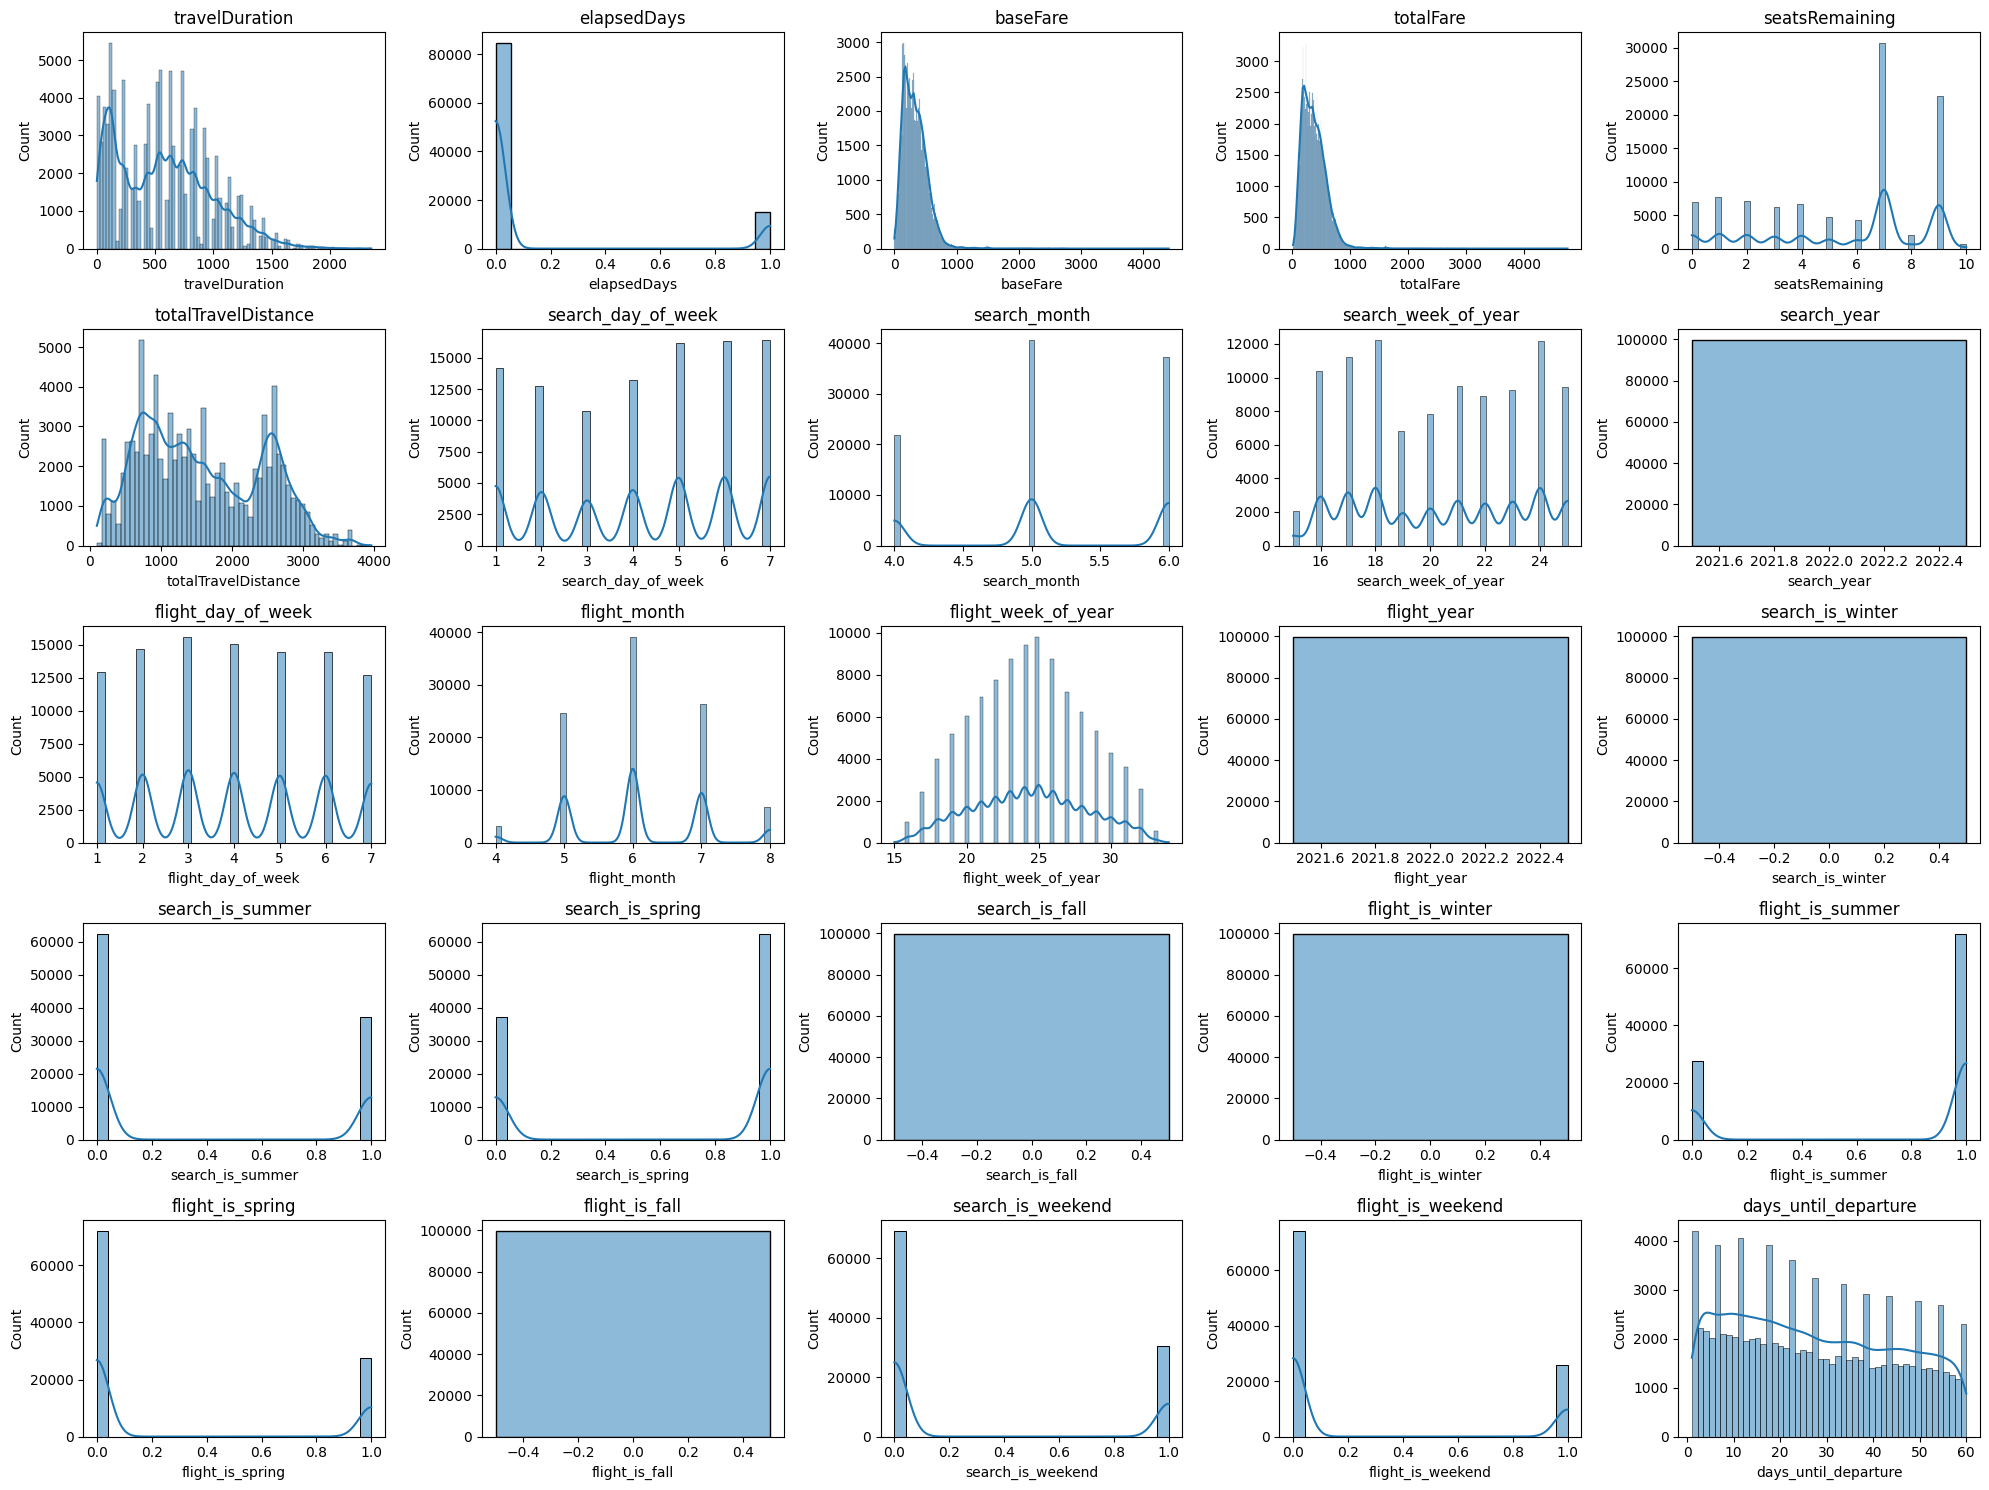

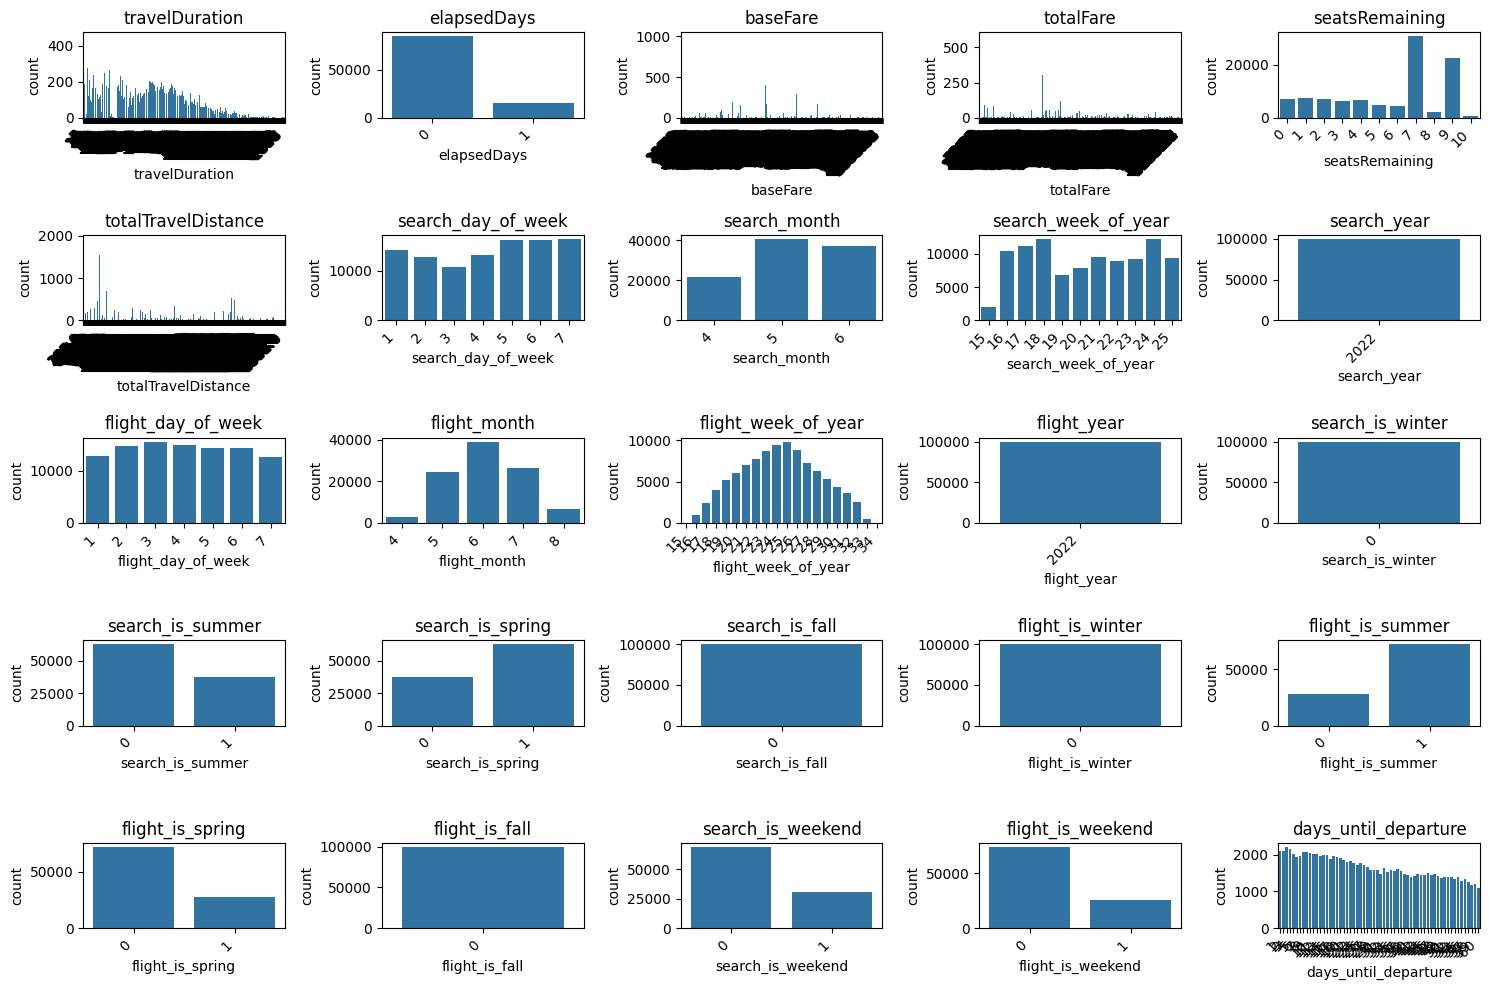

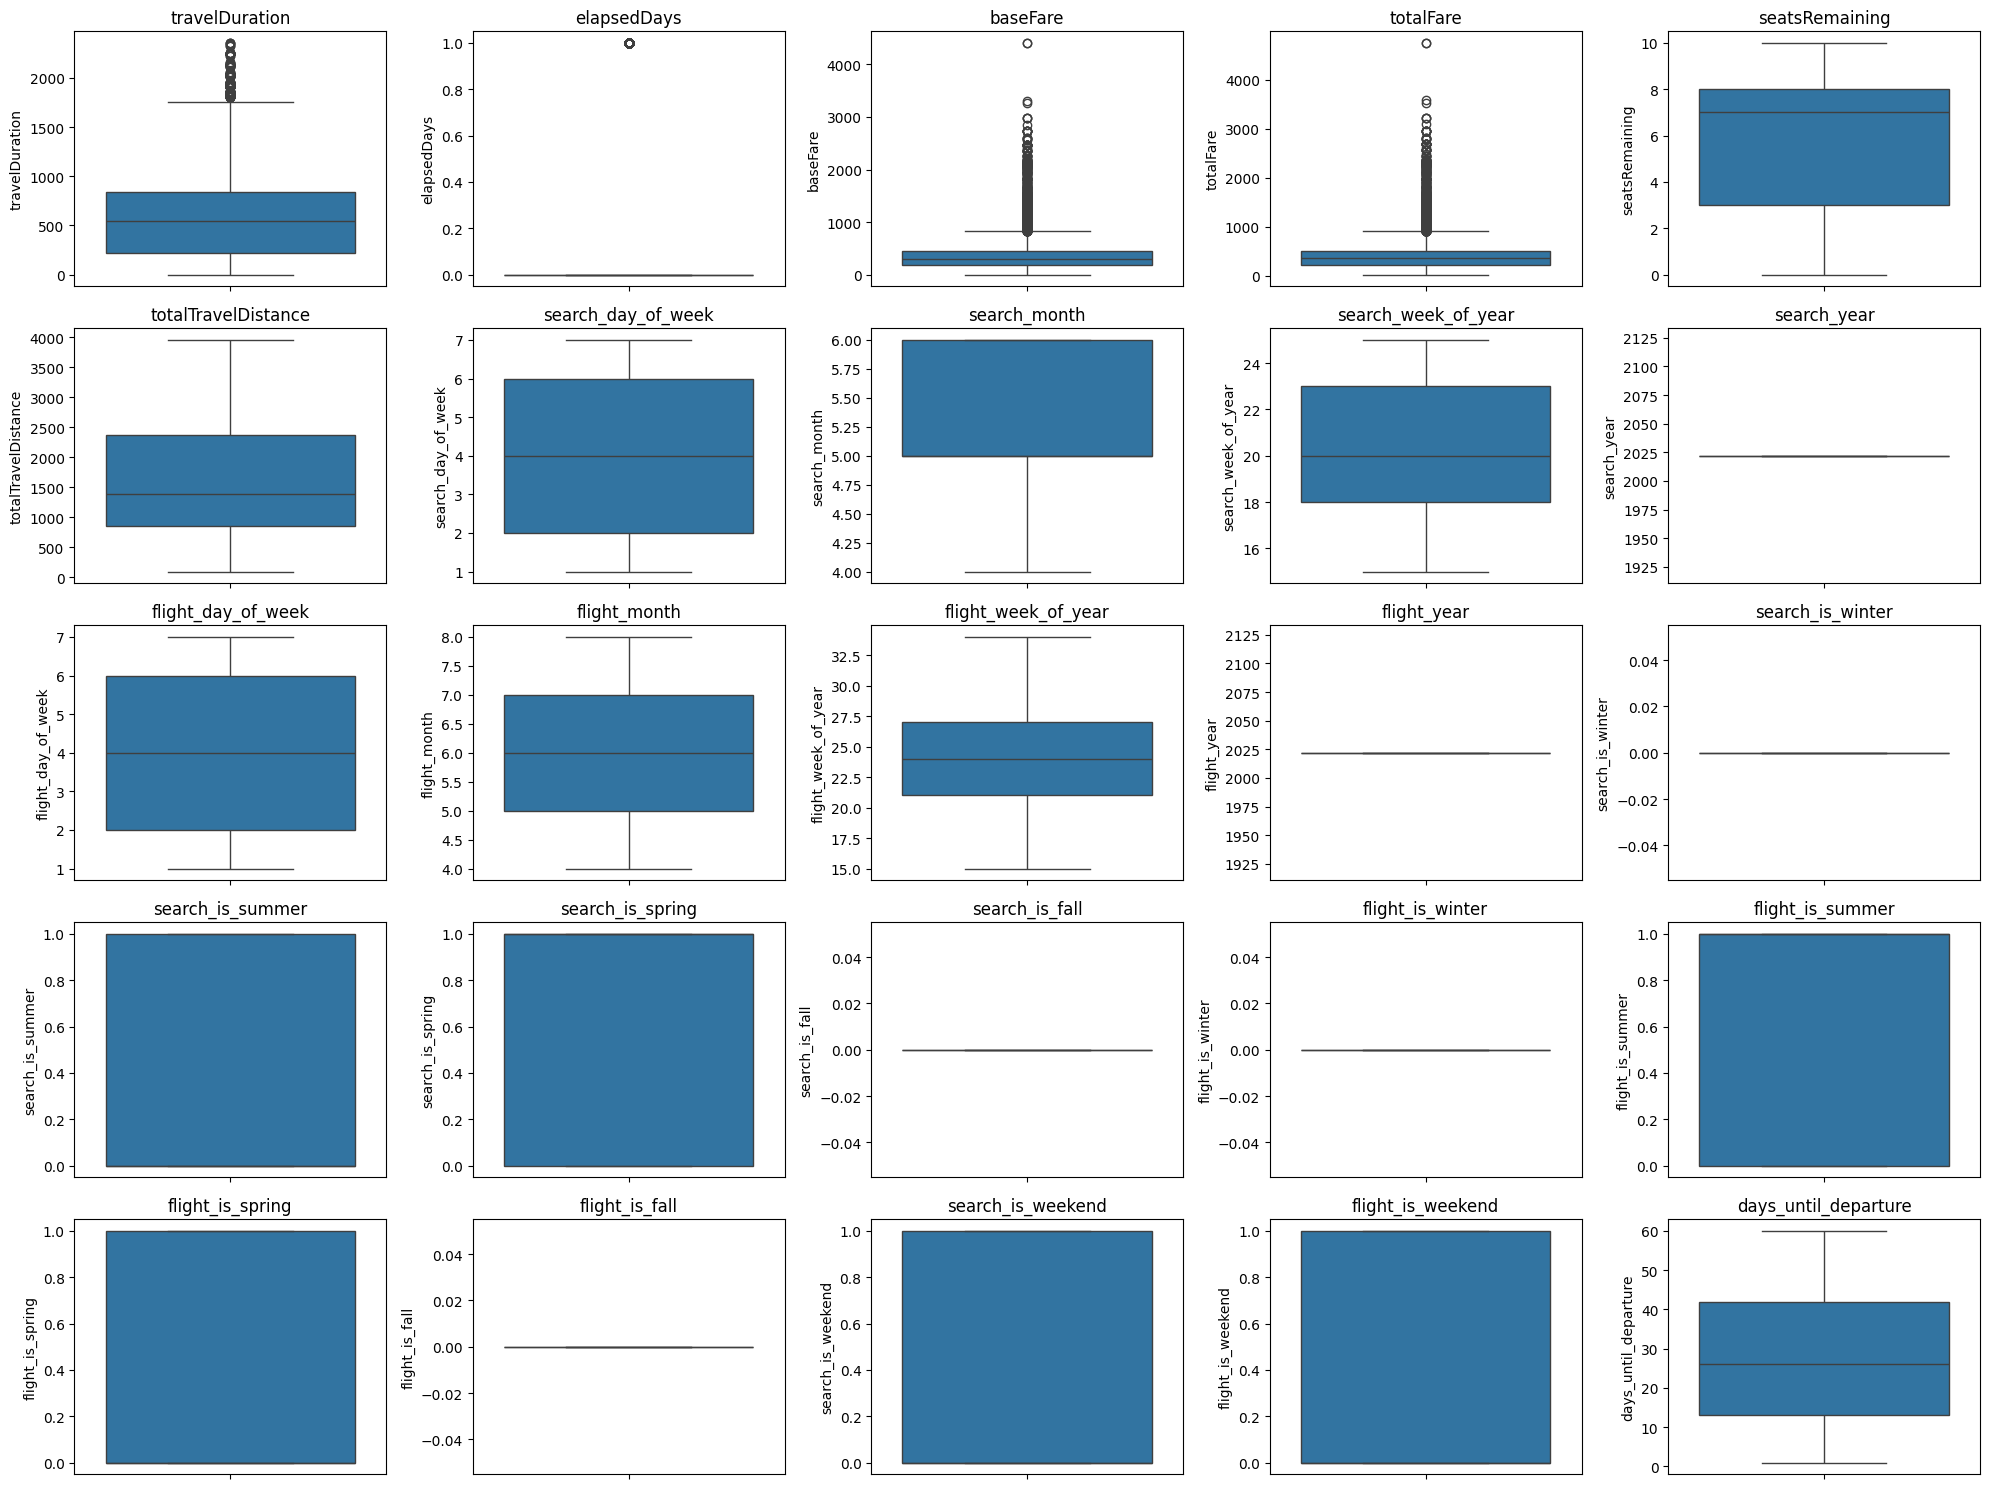

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pandas_df = df_sampled.toPandas()

numerical_cols = [name for name, dtype in df_sampled.dtypes if dtype in ("int", "double", "long", "bigint", "float")]

plt.figure(figsize=(20, 15))
for i, col_name in enumerate(numerical_cols[:25]):
    plt.subplot(5, 5, i + 1)
    sns.histplot(pandas_df[col_name], kde=True)
    plt.title(col_name)
plt.tight_layout()
plt.show()

# 2. Count Plots (for categorical features)
categorical_cols = [name for name, dtype in df_sampled.dtypes if dtype == "string"]

plt.figure(figsize=(15, 10))
for i, col_name in enumerate(numerical_cols[:25]):
    plt.subplot(5, 5, i + 1)
    sns.countplot(x=col_name, data=pandas_df)
    plt.title(col_name)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis
plt.tight_layout()
plt.show()

# 3. Box Plots (for numerical features to visualize outliers)
plt.figure(figsize=(20, 15))
for i, col_name in enumerate(numerical_cols[:25]):
    plt.subplot(5, 5, i + 1)
    sns.boxplot(y=col_name, data=pandas_df)
    plt.title(col_name)
plt.tight_layout()
plt.show()

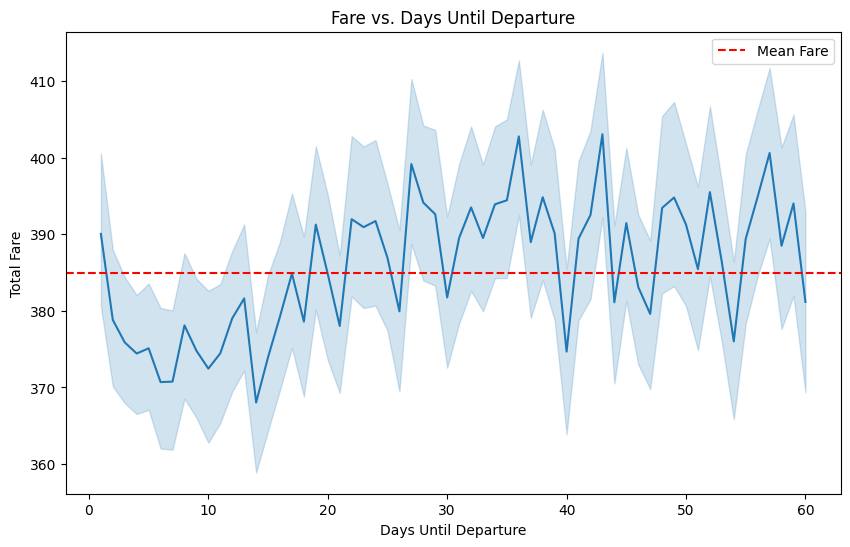

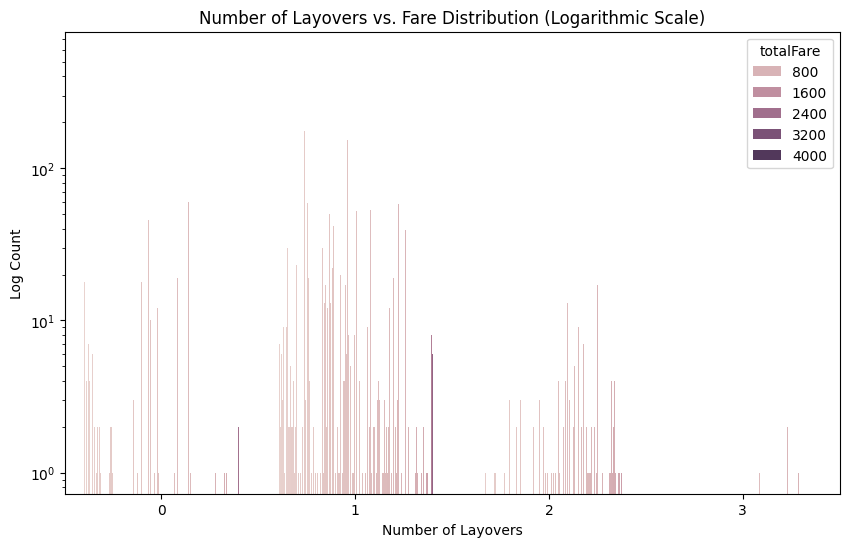

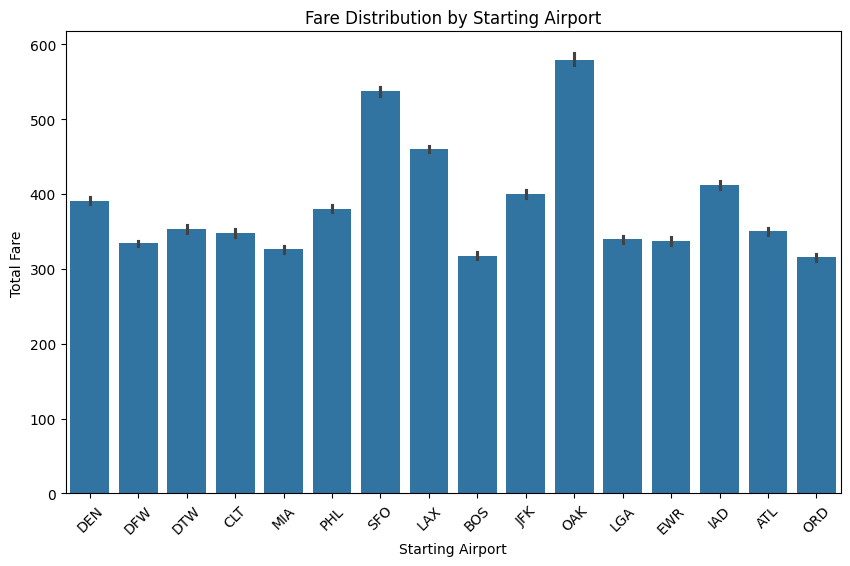

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


 # 1. Non-Linearity of Price vs. Time
plt.figure(figsize=(10, 6))

mean_fare = pandas_df['totalFare'].mean()
# Line graph
sns.lineplot(x='days_until_departure', y='totalFare', data=pandas_df)
# Horizontal reference line for the mean fare
plt.axhline(y=mean_fare, color='red', linestyle='--', label='Mean Fare')

plt.title('Fare vs. Days Until Departure')
plt.xlabel('Days Until Departure')
plt.ylabel('Total Fare')
plt.legend()  # legend for the reference line
plt.show()

# 2. Impact of Layovers (Bar Chart with Logarithmic Scale)
plt.figure(figsize=(10, 6))
sns.countplot(x='num_layovers', hue='totalFare', data=pandas_df)
plt.yscale('log')  # Apply logarithmic scaling to the y-axis
plt.title('Number of Layovers vs. Fare Distribution (Logarithmic Scale)')
plt.xlabel('Number of Layovers')
plt.ylabel('Log Count')
plt.show()

# 3. Airport-Specific Pricing (Bar Chart)
plt.figure(figsize=(10, 6))
sns.barplot(x='startingAirport', y='totalFare', data=pandas_df)  # Bar chart for fare by airport
plt.title('Fare Distribution by Starting Airport')
plt.xlabel('Starting Airport')
plt.ylabel('Total Fare')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability if needed
plt.show()

<ipython-input-7-59ce8294ede6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pandas_df, x='flight_day_of_week', palette="viridis")


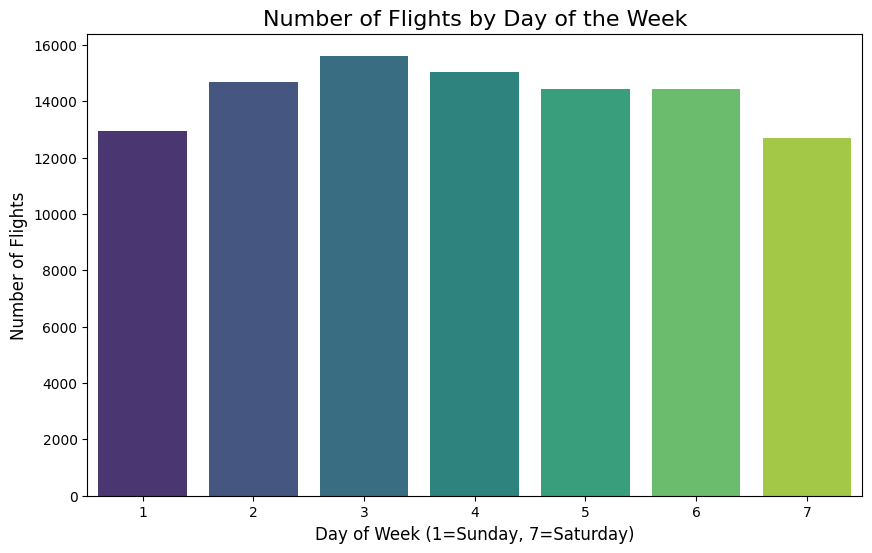

In [7]:
# Number of Flights by Day of the Week
plt.figure(figsize=(10, 6))
sns.countplot(data=pandas_df, x='flight_day_of_week', palette="viridis")
plt.title("Number of Flights by Day of the Week", fontsize=16)
plt.xlabel("Day of Week (1=Sunday, 7=Saturday)", fontsize=12)
plt.ylabel("Number of Flights", fontsize=12)
plt.show()

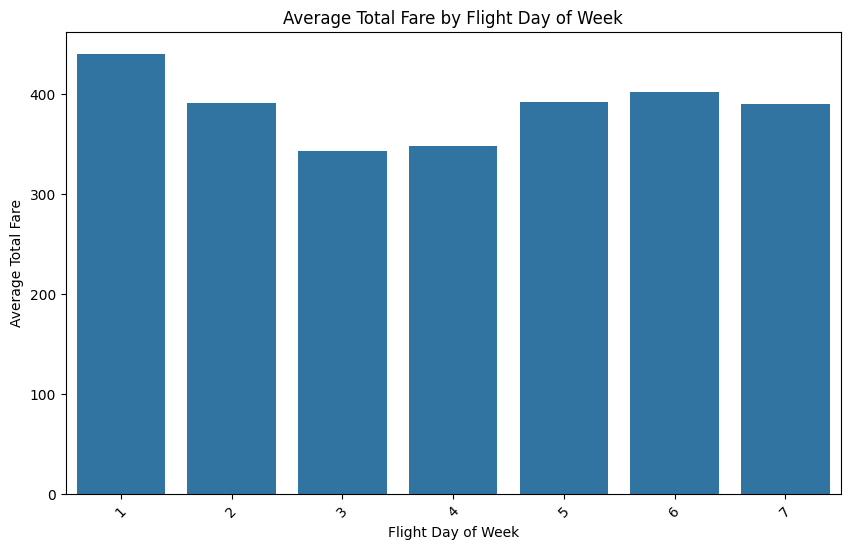

In [8]:
# Flights by Day of the Week vs TotalFare

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Average totalFare for each flight_day_of_week
avg_fare_by_day = df_sampled.groupby('flight_day_of_week').agg({'totalFare': 'mean'})

avg_fare_by_day = avg_fare_by_day.withColumnRenamed('avg(totalFare)', 'avg_totalFare')

avg_fare_by_day_pd = avg_fare_by_day.toPandas()

# Bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='flight_day_of_week', y='avg_totalFare', data=avg_fare_by_day_pd)
plt.title('Average Total Fare by Flight Day of Week')
plt.xlabel('Flight Day of Week')
plt.ylabel('Average Total Fare')
plt.xticks(rotation=45)
plt.show()

In [9]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.window import Window

# Numerical columns
numerical_cols = [name for name, dtype in df_sampled.dtypes if dtype in ("int", "double", "long", "bigint", "float")]

# Calculate Q1, Q3, and IQR for a given column
def calculate_iqr(col_name):
    q1 = df_sampled.approxQuantile(col_name, [0.25], 0.01)[0]
    q3 = df_sampled.approxQuantile(col_name, [0.75], 0.01)[0]
    iqr = q3 - q1
    return q1, q3, iqr

# Filtering out outliers for each numerical column
for col_name in numerical_cols:
    q1, q3, iqr = calculate_iqr(col_name)
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df_sampled = df_sampled.filter((F.col(col_name) >= lower_bound) & (F.col(col_name) <= upper_bound))


In [10]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import DoubleType
from scipy.stats import skew


numerical_cols = [name for name, dtype in df_sampled.dtypes if dtype in ("int", "double", "long", "bigint", "float")]

# Function to calculate skewness utilised scipy.stats
def calculate_skewness(col_name):
    data = df_sampled.select(col_name).dropna().collect()
    data_list = [row[col_name] for row in data]
    if not data_list:  # Checking for empty data
        return None
    try:
        return skew(data_list)
    except Exception as e:
        print(f"Error calculating skewness for {col_name}: {e}")
        return None

# Skewness for each numerical column and print the results
skewness_results = {}
for col_name in numerical_cols:
    skewness_value = calculate_skewness(col_name)
    skewness_results[col_name] = skewness_value

# Skewness values
for col_name, skewness in skewness_results.items():
    print(f"Skewness of {col_name}: {skewness}")

<ipython-input-10-8a52949f0e3f>:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return skew(data_list)


Skewness of travelDuration: 0.4616625878583375
Skewness of elapsedDays: nan
Skewness of baseFare: 0.5337901177557833
Skewness of totalFare: 0.516658982527647
Skewness of seatsRemaining: -0.5603028017748672
Skewness of totalTravelDistance: 0.46726727662551676
Skewness of search_day_of_week: -0.143531049694681
Skewness of search_month: -0.26784983738568297
Skewness of search_week_of_year: -0.0010877247780997131
Skewness of search_year: nan
Skewness of flight_day_of_week: 0.024970606750106535
Skewness of flight_month: 0.10897096773941231
Skewness of flight_week_of_year: 0.04409050024060097
Skewness of flight_year: nan
Skewness of search_is_winter: nan
Skewness of search_is_summer: 0.500195054987796
Skewness of search_is_spring: -0.500195054987796
Skewness of search_is_fall: nan
Skewness of flight_is_winter: nan
Skewness of flight_is_summer: -0.9650616559958819
Skewness of flight_is_spring: 0.9650616559958826
Skewness of flight_is_fall: nan
Skewness of search_is_weekend: 0.8078607353179948

In [11]:
import math
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit, when, length, trim, isnan, avg, array, struct, sort_array, collect_list, explode, sqrt, sum as spark_sum, udf, size, slice
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.sql.types import DoubleType
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from pyspark.sql.functions import pandas_udf, PandasUDFType

def check_missing_values(df):
    """Checks for various types of missing values in a DataFrame."""
    missing_counts = {}
    total_rows = df.count()

    for col_name in df.columns:
        blank_count = 0  # Initialize blank_count

        # Checking for NULLs
        null_count = df.filter(col(col_name).isNull()).count()

        # Checking for empty strings (blanks)
        blank_count = df.filter(length(trim(col(col_name))) == 0).count()  # Update blank_count

        # Checking for 0.0 (if the column is numeric)
        if df.schema[col_name].dataType.typeName() in ("integer", "double", "float"):
            zero_count = df.filter(col(col_name) == 0.0).count()
        else:
            zero_count = 0

        total_missing = null_count + blank_count + zero_count
        missing_counts[col_name] = {
            "nulls": null_count,
            "blanks": blank_count,
            "zeros": zero_count,
            "total_missing": total_missing,
            "percentage_missing": (total_missing / total_rows) * 100 if total_rows > 0 else 0
        }
    return missing_counts

In [12]:
# Checking for Missing value
missings = check_missing_values(df_sampled)
for col_name, counts in missings.items():
    if counts["total_missing"] > 0:
        print(f"Column '{col_name}':")
        print(f"  Nulls: {counts['nulls']}")
        print(f"  Blanks: {counts['blanks']}")
        print(f"  Zeros: {counts['zeros']}")
        print(f"  Total Missing: {counts['total_missing']}")
        print(f"  Percentage Missing: {counts['percentage_missing']:.2f}%")

df_sampled.show(5)

Column 'elapsedDays':
  Nulls: 0
  Blanks: 0
  Zeros: 47625
  Total Missing: 47625
  Percentage Missing: 100.00%
Column 'search_is_winter':
  Nulls: 0
  Blanks: 0
  Zeros: 47625
  Total Missing: 47625
  Percentage Missing: 100.00%
Column 'search_is_summer':
  Nulls: 0
  Blanks: 0
  Zeros: 29590
  Total Missing: 29590
  Percentage Missing: 62.13%
Column 'search_is_spring':
  Nulls: 0
  Blanks: 0
  Zeros: 18035
  Total Missing: 18035
  Percentage Missing: 37.87%
Column 'search_is_fall':
  Nulls: 0
  Blanks: 0
  Zeros: 47625
  Total Missing: 47625
  Percentage Missing: 100.00%
Column 'flight_is_winter':
  Nulls: 0
  Blanks: 0
  Zeros: 47625
  Total Missing: 47625
  Percentage Missing: 100.00%
Column 'flight_is_summer':
  Nulls: 0
  Blanks: 0
  Zeros: 13464
  Total Missing: 13464
  Percentage Missing: 28.27%
Column 'flight_is_spring':
  Nulls: 0
  Blanks: 0
  Zeros: 34161
  Total Missing: 34161
  Percentage Missing: 71.73%
Column 'flight_is_fall':
  Nulls: 0
  Blanks: 0
  Zeros: 47625
  To

In [13]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, DoubleType
import math

def calculate_k(n_rows):
    """Dynamically calculate the value of k based on the number of rows."""
    k = int(math.sqrt(n_rows))  # Square root rule for k
    return max(1, min(k, 10))  # k is between 1 and 10

def knn_imputation_spark(df, cols_to_impute=None):
    """
    Perform KNN imputation on specified columns using Spark with dynamic k.

    Parameters:
    df (DataFrame): The input Spark DataFrame
    cols_to_impute (list): List of column names to impute

    Returns:
    DataFrame: DataFrame with missing values imputed
    """
    n_rows = df.count()

    # Dynamically calculate the number of neighbors (k)
    k = calculate_k(n_rows)
    print(f"Using k = {k} for KNN imputation")

    # Assemble features into a vector column for KMeans
    assembler = VectorAssembler(inputCols=cols_to_impute, outputCol="features")
    df_with_features = assembler.transform(df).select("features", *cols_to_impute)

    # Fit KMeans model to find clusters
    kmeans = KMeans(k=k, seed=1, featuresCol="features", predictionCol="cluster")
    model = kmeans.fit(df_with_features)
    df_with_neighbors = model.transform(df_with_features)

    # Handle missing values in specified columns
    for col_name in cols_to_impute:
        # Filter out rows with missing values in the column
        missing_rows = df_with_neighbors.filter(F.col(col_name).isNull())

        for row in missing_rows.collect():
            # For each missing row, find the nearest neighbors based on cluster
            cluster_id = row['cluster']
            neighbors = df_with_neighbors.filter(F.col('cluster') == cluster_id).collect()

            # Get the neighbors values for the column to impute
            neighbor_values = [neighbor[col_name] for neighbor in neighbors if neighbor[col_name] is not None]

            if neighbor_values:
                # Impute the missing value with the mean of the neighbors
                imputed_value = sum(neighbor_values) / len(neighbor_values)
                df = df.withColumn(col_name, F.when(F.col(col_name).isNull(), imputed_value).otherwise(F.col(col_name)))

    return df


cols_to_impute = ['totalTravelDistance', 'price_per_mile']
df_sampled = knn_imputation_spark(df_sampled, cols_to_impute=cols_to_impute)

df_sampled.show()


Using k = 10 for KNN imputation
+---------------+------------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+------------------+------------+-------------------+-----------+------------------+------------+-------------------+-----------+----------------+----------------+----------------+--------------+----------------+----------------+----------------+--------------+-----------------+-----------------+--------------------+---------+------------+------------+------------------+------------------+-------------------+----------------------------+---------------------------------+------------------------------+-----------+-----------+-----------+-----------+--------------------+-------------------+------------------+-------------------+
|startingAirport|destinationAirport|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|search_day_of_week|searc

In [14]:
df_sampled.printSchema()


root
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- travelDuration: integer (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- search_day_of_week: integer (nullable = true)
 |-- search_month: integer (nullable = true)
 |-- search_week_of_year: integer (nullable = true)
 |-- search_year: integer (nullable = true)
 |-- flight_day_of_week: integer (nullable = true)
 |-- flight_month: integer (nullable = true)
 |-- flight_week_of_year: integer (nullable = true)
 |-- flight_year: integer (nullable = true)
 |-- search_is_winter: integer (nullable = true)
 |-- search_is_summer: integer (nullable = true)
 |-- search

In [15]:
from pyspark.sql.functions import col
import pyspark.sql.functions as F

# Drop elapsedDays
df_sampled = df_sampled.drop("elapsedDays")

# Handle seasonality features
season_cols = ["search_is_winter", "search_is_summer", "search_is_spring", "search_is_fall",
               "flight_is_winter", "flight_is_summer", "flight_is_spring", "flight_is_fall"]

df_sampled = df_sampled.withColumn("search_season",
                   when(col("search_is_winter") == 1, "winter")
                   .when(col("search_is_summer") == 1, "summer")
                   .when(col("search_is_spring") == 1, "spring")
                   .when(col("search_is_fall") == 1, "fall")
                   .otherwise("unknown"))

df_sampled = df_sampled.withColumn("flight_season",
                   when(col("flight_is_winter") == 1, "winter")
                   .when(col("flight_is_summer") == 1, "summer")
                   .when(col("flight_is_spring") == 1, "spring")
                   .when(col("flight_is_fall") == 1, "fall")
                   .otherwise("unknown"))

df_sampled = df_sampled.drop(*season_cols)

# Handle fare_difference
df_sampled = df_sampled.withColumn("fare_difference", col("baseFare") - col("totalFare"))

# Handle fare_ratio

df_sampled = df_sampled.withColumn("price_per_mile", when(col("totalTravelDistance") != 0, col("baseFare") / col("totalTravelDistance")).otherwise(lit(0)))

# Handle leg_route columns
leg_route_cols = ["leg_route_2", "leg_route_3", "leg_route_4"]
for col_name in leg_route_cols:
    df_sampled = df_sampled.withColumn(col_name, when(length(trim(col(col_name))) == 0, "no_leg").otherwise(col(col_name)))

# Handle lowest_cabin_class
df_sampled = df_sampled.withColumn("lowest_cabin_class", when(col("lowest_cabin_class").isNull(), "coach").otherwise(col("lowest_cabin_class")))



In [16]:
# --- Missing value check after transformations ---
missings = check_missing_values(df_sampled)
for col_name, counts in missings.items():
    if counts["total_missing"] > 0:
        print(f"Column '{col_name}':")
        print(f"  Nulls: {counts['nulls']}")
        print(f"  Blanks: {counts['blanks']}")
        print(f"  Zeros: {counts['zeros']}")
        print(f"  Total Missing: {counts['total_missing']}")
        print(f"  Percentage Missing: {counts['percentage_missing']:.2f}%")

df_sampled.show(5)

Column 'search_is_weekend':
  Nulls: 0
  Blanks: 0
  Zeros: 32731
  Total Missing: 32731
  Percentage Missing: 68.73%
Column 'flight_is_weekend':
  Nulls: 0
  Blanks: 0
  Zeros: 47625
  Total Missing: 47625
  Percentage Missing: 100.00%
Column 'num_layovers':
  Nulls: 0
  Blanks: 0
  Zeros: 15858
  Total Missing: 15858
  Percentage Missing: 33.30%
Column 'Flight_is_weekend_x_total_fare':
  Nulls: 0
  Blanks: 0
  Zeros: 47625
  Total Missing: 47625
  Percentage Missing: 100.00%
+---------------+------------------+--------------+--------------+------------+---------+--------+---------+--------------+-------------------+------------------+------------+-------------------+-----------+------------------+------------+-------------------+-----------+-----------------+-----------------+--------------------+---------+------------+------------+-------------------+------------------+-------------------+----------------------------+---------------------------------+------------------------------+-

In [17]:
from pyspark.sql.types import StringType, IntegerType, DoubleType, LongType, BooleanType

categorical_cols = [name for name, dtype in df_sampled.dtypes  if dtype == "string"]
numerical_cols = [name for name, dtype in df_sampled.dtypes if dtype in ("int", "double", "long", "bigint", "float")] #Added more numerical types
boolean_cols = [name for name, dtype in df_sampled.dtypes  if dtype == "boolean"]

print("Categorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)
print("Boolean Columns:", boolean_cols)

Categorical Columns: ['startingAirport', 'destinationAirport', 'day_part', 'distance_bin', 'leg_route_1', 'leg_route_2', 'leg_route_3', 'leg_route_4', 'airline_combination', 'highest_cabin_class', 'lowest_cabin_class', 'search_season', 'flight_season']
Numerical Columns: ['travelDuration', 'baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance', 'search_day_of_week', 'search_month', 'search_week_of_year', 'search_year', 'flight_day_of_week', 'flight_month', 'flight_week_of_year', 'flight_year', 'search_is_weekend', 'flight_is_weekend', 'days_until_departure', 'num_layovers', 'fare_difference', 'fare_ratio', 'price_per_mile', 'seats_remaining_x_total_fare', 'days_until_departure_x_total_fare', 'Flight_is_weekend_x_total_fare', 'cabin_class_changes']
Boolean Columns: ['isBasicEconomy', 'isRefundable', 'isNonStop']


In [18]:
# Encoding
from pyspark.ml.feature import StringIndexer, OneHotEncoder

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep").fit(df_sampled) for column in categorical_cols]
for indexer in indexers:
    df_sampled = indexer.transform(df_sampled)

encoders = [OneHotEncoder(inputCol=column+"_index", outputCol=column+"_encoded").fit(df_sampled) for column in categorical_cols]
for encoder in encoders:
    df_sampled = encoder.transform(df_sampled)

In [19]:
df_sampled = df_sampled.drop(*categorical_cols)

In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.types import *


for col_name in boolean_cols:
    df_sampled = df_sampled.withColumn(col_name, when(col(col_name) == True, 1).when(col(col_name) == False, 0).otherwise(0).cast("int"))


In [21]:
df_sampled = df_sampled.drop("baseFare")

In [22]:
# --- Remove Indexed Categorical Columns ---
index_cols = [c for c in df_sampled.columns if c.endswith("_index")]
df_sampled = df_sampled.drop(*index_cols)

In [23]:
columns_to_drop = [
    "isBasicEconomy", "isRefundable", "isNonStop", "search_year", "flight_year",
    "search_is_fall", "flight_is_winter", "flight_is_fall", "lowest_cabin_class_index",
    "search_week_of_year", "flight_week_of_year"
]

df_sampled = df_sampled.drop(*columns_to_drop) # * unpacks the list into separate arguments


In [24]:
df_sampled.printSchema()

root
 |-- travelDuration: integer (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- search_day_of_week: integer (nullable = true)
 |-- search_month: integer (nullable = true)
 |-- flight_day_of_week: integer (nullable = true)
 |-- flight_month: integer (nullable = true)
 |-- search_is_weekend: integer (nullable = true)
 |-- flight_is_weekend: integer (nullable = true)
 |-- days_until_departure: integer (nullable = true)
 |-- num_layovers: integer (nullable = true)
 |-- fare_difference: double (nullable = true)
 |-- fare_ratio: double (nullable = true)
 |-- price_per_mile: double (nullable = true)
 |-- seats_remaining_x_total_fare: double (nullable = true)
 |-- days_until_departure_x_total_fare: double (nullable = true)
 |-- Flight_is_weekend_x_total_fare: double (nullable = true)
 |-- cabin_class_changes: integer (nullable = true)
 |-- startingAirport_encoded: vector (nullab

                                   travelDuration  totalFare  seatsRemaining  \
travelDuration                           1.000000   0.445029       -0.116214   
totalFare                                0.445029   1.000000       -0.073757   
seatsRemaining                          -0.116214  -0.073757        1.000000   
totalTravelDistance                      0.538580   0.667405       -0.093020   
search_day_of_week                      -0.004873   0.012317        0.008084   
search_month                            -0.000279   0.031268       -0.001224   
flight_day_of_week                      -0.005344   0.031567       -0.012569   
flight_month                            -0.022014  -0.023507        0.128764   
search_is_weekend                        0.002167  -0.001518        0.001181   
flight_is_weekend                             NaN        NaN             NaN   
days_until_departure                    -0.037675  -0.041123        0.202116   
num_layovers                            

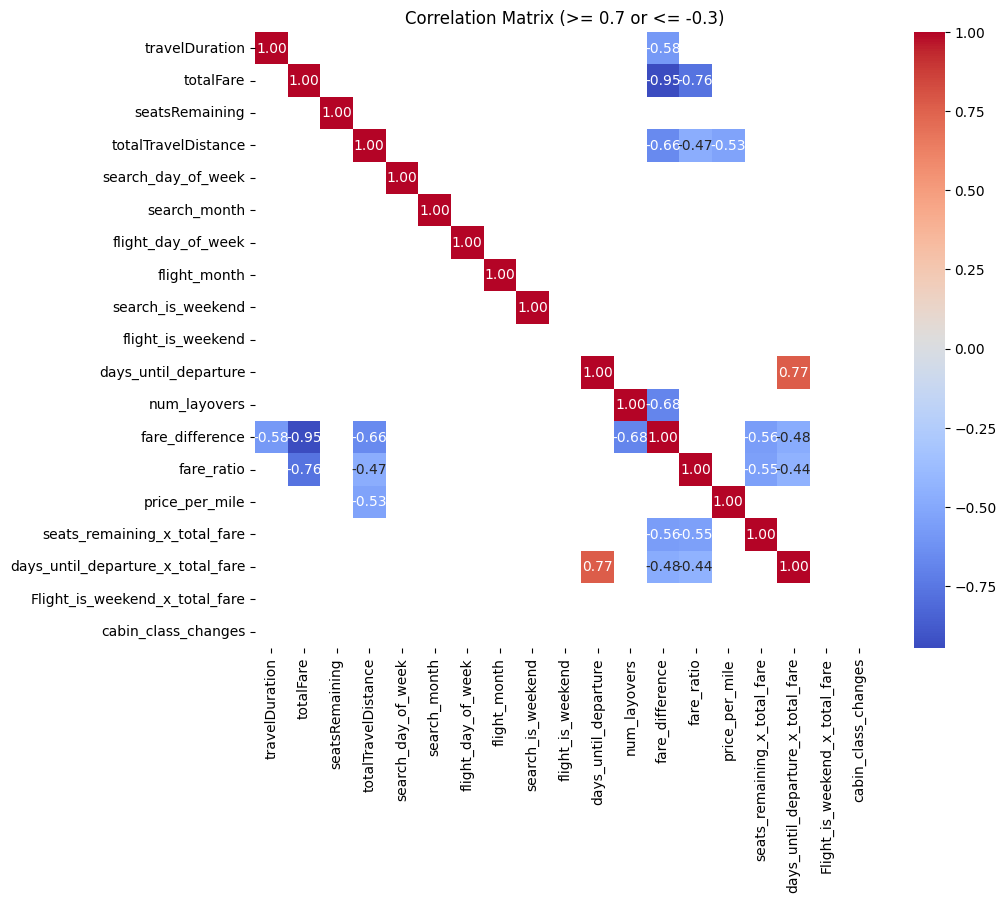

In [25]:
numerical_cols_with_bool = [name for name, dtype in df_sampled.dtypes if dtype in ("int", "double", "long", "bigint", "float")]

#correlation matrix
correlation_matrix = df_sampled.select(numerical_cols_with_bool).toPandas().corr()

print(correlation_matrix)

# Correlation matrix plotting
import matplotlib.pyplot as plt
import seaborn as sns

threshold_positive = 0.7
threshold_negative = -0.3

# Mask for values outside the desired range
mask = (correlation_matrix >= threshold_positive) | (correlation_matrix <= threshold_negative)

correlation_matrix_masked = correlation_matrix.copy()

correlation_matrix_masked[~mask] = np.nan

# heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(correlation_matrix_masked, annot=True, cmap='coolwarm', fmt=".2f")  # fmt for decimal places
plt.title('Correlation Matrix (>= 0.7 or <= -0.3)')
plt.show()


In [26]:
# removing because of high correlation
columns_to_drop = ["search_is_summer", "flight_is_summer"]
df_sampled = df_sampled.drop(*columns_to_drop)

In [27]:
numerical_cols = [name for name, dtype in df_sampled.dtypes if dtype in ("int", "double", "long", "bigint", "float")]

numerical_cols

['travelDuration',
 'totalFare',
 'seatsRemaining',
 'totalTravelDistance',
 'search_day_of_week',
 'search_month',
 'flight_day_of_week',
 'flight_month',
 'search_is_weekend',
 'flight_is_weekend',
 'days_until_departure',
 'num_layovers',
 'fare_difference',
 'fare_ratio',
 'price_per_mile',
 'seats_remaining_x_total_fare',
 'days_until_departure_x_total_fare',
 'Flight_is_weekend_x_total_fare',
 'cabin_class_changes']

In [28]:
from pyspark.sql.functions import col, when, lit, length, trim
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [29]:
df_sampled.printSchema()

root
 |-- travelDuration: integer (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- search_day_of_week: integer (nullable = true)
 |-- search_month: integer (nullable = true)
 |-- flight_day_of_week: integer (nullable = true)
 |-- flight_month: integer (nullable = true)
 |-- search_is_weekend: integer (nullable = true)
 |-- flight_is_weekend: integer (nullable = true)
 |-- days_until_departure: integer (nullable = true)
 |-- num_layovers: integer (nullable = true)
 |-- fare_difference: double (nullable = true)
 |-- fare_ratio: double (nullable = true)
 |-- price_per_mile: double (nullable = true)
 |-- seats_remaining_x_total_fare: double (nullable = true)
 |-- days_until_departure_x_total_fare: double (nullable = true)
 |-- Flight_is_weekend_x_total_fare: double (nullable = true)
 |-- cabin_class_changes: integer (nullable = true)
 |-- startingAirport_encoded: vector (nullab

In [30]:
feature_cols = [
    "totalTravelDistance",
    "search_day_of_week", "search_month", "flight_day_of_week", "flight_month",
    "search_is_weekend", "flight_is_weekend", "days_until_departure",
    "num_layovers", "cabin_class_changes",
    "startingAirport_encoded", "destinationAirport_encoded", "day_part_encoded",
    "distance_bin_encoded", "leg_route_1_encoded","leg_route_2_encoded","leg_route_3_encoded","leg_route_4_encoded", "airline_combination_encoded",
    "highest_cabin_class_encoded", "lowest_cabin_class_encoded", "fare_difference", "price_per_mile",
    "seats_remaining_x_total_fare",
    "search_season_encoded", "flight_season_encoded"
]

numerical_cols = [name for name in feature_cols if df_sampled.schema[name].dataType.typeName() in ("int", "long", "bigint", "float")]
for col_name in numerical_cols:
    df_sampled = df_sampled.withColumn(col_name, col(col_name).cast("double"))

# Assemble features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_assembled = assembler.transform(df_sampled)

# Scale Features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# Target Variable
target_variable = "totalFare"
df_scaled = df_scaled.withColumn(target_variable, col(target_variable).cast("double"))

# Drop original features and features column
df_scaled = df_scaled.drop(*feature_cols,"features")

# Train-Test Split
(trainingData, testData) = df_scaled.randomSplit([0.8, 0.2], seed=42)

In [31]:
df_scaled.printSchema()

root
 |-- travelDuration: integer (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- fare_ratio: double (nullable = true)
 |-- days_until_departure_x_total_fare: double (nullable = true)
 |-- Flight_is_weekend_x_total_fare: double (nullable = true)
 |-- scaled_features: vector (nullable = true)



In [32]:
# With Optimizations

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.regression import GBTRegressor, RandomForestRegressor, LinearRegression, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler

# --- Model Training and Evaluation ---
models = {
    "GBTRegressor": GBTRegressor(featuresCol="scaled_features", labelCol=target_variable),
    "RandomForestRegressor": RandomForestRegressor(featuresCol="scaled_features", labelCol=target_variable),
    "LinearRegression": LinearRegression(featuresCol="scaled_features", labelCol=target_variable),
    "DecisionTreeRegressor": DecisionTreeRegressor(featuresCol="scaled_features", labelCol=target_variable)
}

paramGrids = {
    "GBTRegressor": ParamGridBuilder() \
        .addGrid(models["GBTRegressor"].maxDepth, [5, 10]) \
        .addGrid(models["GBTRegressor"].maxIter, [20, 50]) \
        .addGrid(models["GBTRegressor"].stepSize, [0.01, 0.1]) \
        .build(),
    "RandomForestRegressor": ParamGridBuilder() \
        .addGrid(models["RandomForestRegressor"].numTrees, [10, 20]) \
        .addGrid(models["RandomForestRegressor"].maxDepth, [5, 10]) \
        .build(),
    "LinearRegression": ParamGridBuilder() \
        .addGrid(models["LinearRegression"].regParam, np.logspace(-2, 0, 5)) \
        .build(),
    "DecisionTreeRegressor": ParamGridBuilder() \
        .addGrid(models["DecisionTreeRegressor"].maxDepth, [5, 10, 20]) \
        .build()
}

evaluator = RegressionEvaluator(labelCol=target_variable, predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol=target_variable, predictionCol="prediction", metricName="r2")

results = {}

for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")
    cv = CrossValidator(estimator=model,
                      estimatorParamMaps=paramGrids[model_name],
                      evaluator=evaluator,
                      numFolds=3)
    cvModel = cv.fit(trainingData)
    predictions = cvModel.transform(testData)
    rmse = evaluator.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)
    results[model_name] = {"rmse": rmse, "r2": r2}

# Print the results
for model_name, metrics in results.items():
    print(f"{model_name} - RMSE: {metrics['rmse']}, R2: {metrics['r2']}")

Training and evaluating GBTRegressor...
Training and evaluating RandomForestRegressor...
Training and evaluating LinearRegression...
Training and evaluating DecisionTreeRegressor...
GBTRegressor - RMSE: 12.60286509668212, R2: 0.993142337760419
RandomForestRegressor - RMSE: 16.868226110676115, R2: 0.9877149665377364
LinearRegression - RMSE: 18.47986201661948, R2: 0.9852553331502814
DecisionTreeRegressor - RMSE: 15.258922277819014, R2: 0.9899472417707649
